In [0]:
from google.colab import files
import tensorflow as tf
import matplotlib as pyplot
import pandas as pd
import warnings
import logging
import matplotlib.pyplot as plt

In [0]:
uploaded = files.upload()

In [0]:
warnings.simplefilter('ignore')
tf.get_logger().setLevel(logging.ERROR)

In [0]:
dataset_location = './UberDemand.csv'
num_epoch = 60
num_GRU_layers = 4
num_GRU_neurons = 32
dropout = 0.1
NUM_OUTPUT = 4
learning_rate = 0.001
batch_size = 16
num_sample = 100

In [5]:
dataset = pd.read_csv(dataset_location)
dataset.head(5)

,Unnamed: 0,borough,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday,hr_sin,hr_cos,day_sin,day_cos,date
0,0,Bronx,152,5.0,10.0,-1.111111,7.0,1023.5,0.0,0.0,0.0,0.0,1,0.62941,0.982963,0.716942,0.049516,1/1/2015
1,1,Brooklyn,1519,5.0,10.0,-1.111111,7.0,1023.5,0.0,0.0,0.0,0.0,1,0.62941,0.982963,0.716942,0.049516,1/1/2015
2,2,Manhattan,5258,5.0,10.0,-1.111111,7.0,1023.5,0.0,0.0,0.0,0.0,1,0.62941,0.982963,0.716942,0.049516,1/1/2015
3,3,Queens,405,5.0,10.0,-1.111111,7.0,1023.5,0.0,0.0,0.0,0.0,1,0.62941,0.982963,0.716942,0.049516,1/1/2015
4,4,Bronx,120,3.0,10.0,-1.111111,6.0,1023.0,0.0,0.0,0.0,0.0,1,0.75000,0.933013,0.716942,0.049516,1/1/2015


In [0]:
X_data = dataset.iloc[:, 3:-1]
y_data = dataset.iloc[:, 2:3]

In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
sc_x = MinMaxScaler()
sc_y = MinMaxScaler()

In [0]:
scaled_X_data = sc_x.fit_transform(X_data)
scaled_y_data = sc_y.fit_transform(y_data)

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
# capture 6 hours 
def gen_data():
    for index in range(24, scaled_X_data.shape[0], 4):
        X = scaled_X_data[index - 24:index, :]
        y = scaled_y_data[index:index + 4, 0:1]
        if len(y) < 4:
            continue
        yield X, y

In [0]:
X, y = [], []
for f, l in gen_data():
    X.append(f)
    y.append(l)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:

def gen_test_data():
    for index in range(len(X_test)):
        yield X_test[index], y_test[index]

In [0]:
def gen_train_data():
    for index in range(len(X_train)):
        yield X_train[index], y_train[index]

In [0]:
train_dataset = tf.data.Dataset.from_generator(gen_train_data, output_types=(tf.float64, tf.float64)).repeat(num_epoch).batch(batch_size=batch_size)
test_dataset = tf.data.Dataset.from_generator(gen_test_data, output_types=(tf.float64, tf.float64)).batch(batch_size=1)

In [0]:
# An iterator to get data from train set
iterator = train_dataset.make_one_shot_iterator()
elements = iterator.get_next()

# An iterator to get data from test set
test_iterator = test_dataset.make_one_shot_iterator()
test_element = test_iterator.get_next()

In [0]:
net_in = tf.placeholder(dtype=tf.float64, shape=(None, 24,14))
net_out = tf.placeholder(dtype=tf.float64, shape=(None, 4, 1))

In [0]:
cell = tf.contrib.rnn.MultiRNNCell(
    [tf.nn.rnn_cell.GRUCell(num_units=num_GRU_neurons, 
                            activation=tf.nn.tanh, 
                             dtype=tf.float64) for _ in range(num_GRU_layers)])

In [0]:
rnn_outputs, states = tf.nn.dynamic_rnn(cell,inputs=net_in, dtype=tf.float64)

In [0]:
last_state = states[-1]

In [0]:

output = tf.layers.dense(inputs=last_state, units=NUM_OUTPUT)

In [0]:
output = tf.reshape(output, [-1, NUM_OUTPUT, 1])

In [0]:
loss = tf.reduce_mean(tf.square(output - net_out))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [0]:
init = tf.global_variables_initializer()

In [0]:
with tf.Session() as sess:
    sess.run(init)
    # train model
    while True:
        try:
            data, labels = sess.run(elements)
            sess.run(train, feed_dict={net_in:data, net_out:labels})
        except tf.errors.OutOfRangeError:
            break
    
    # prediction
    results = []
    while True:
        try:
            data, label = sess.run(test_element)
            logit = sess.run(output, feed_dict={net_in:data})
            results.append((sc_y.inverse_transform(logit.flatten().reshape(-1, 1)), 
                            sc_y.inverse_transform(label.flatten().reshape(-1, 1))))
        except tf.errors.OutOfRangeError:
            break


In [0]:
import random


In [0]:
smpl = random.sample(results,k=num_sample)

In [0]:
# true label
bronx_label = [l[0] for _, l in smpl]
brooklyn_label = [l[1] for _, l in smpl]
manhattan_label = [l[2] for _, l in smpl]
queens_label = [l[3] for _, l in smpl]
    
    

In [0]:
# predicted label
bronx_pred = [p[0] for p, _ in smpl]
brooklyn_pred = [p[1] for p, _ in smpl]
manhattan_pred = [p[2] for p, _ in smpl]
queens_pred = [p[3] for p, _ in smpl]


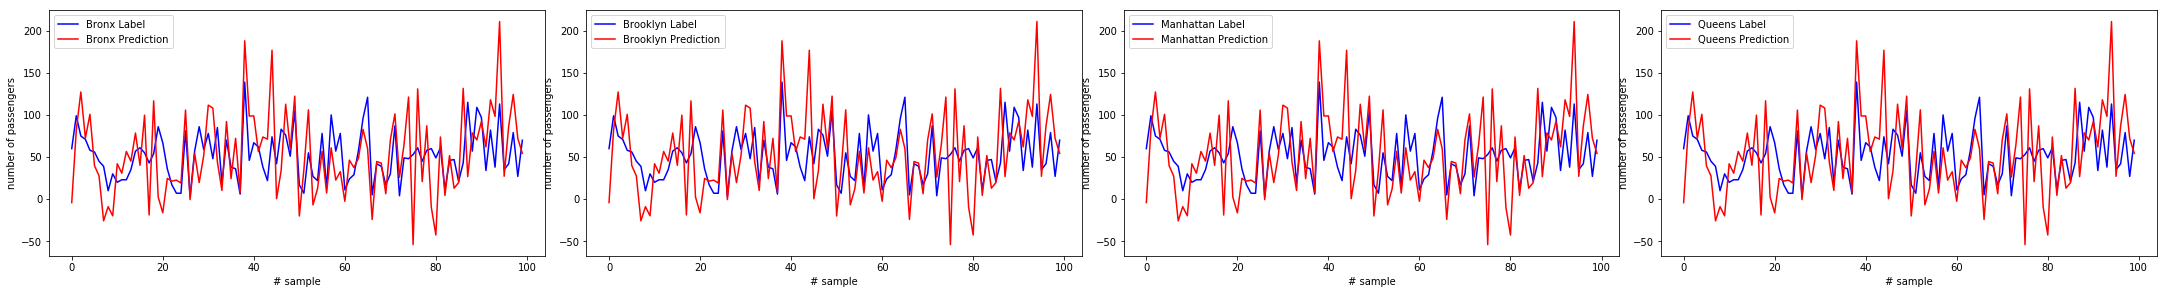

In [31]:
fig, axes = plt.subplots(figsize=(30, 4),nrows=1, ncols=4)
plt.tight_layout()

axes[0].plot(range(num_sample), bronx_label, 'b', label='Bronx Label')
axes[0].plot(range(num_sample), bronx_pred, 'r', label='Bronx Prediction')
axes[0].set_xlabel('# sample')
axes[0].set_ylabel('number of passengers')
axes[0].legend()


axes[1].plot(range(num_sample), bronx_label, 'b', label='Brooklyn Label')
axes[1].plot(range(num_sample), bronx_pred, 'r', label='Brooklyn Prediction')
axes[1].set_xlabel('# sample')
axes[1].set_ylabel('number of passengers')
axes[1].legend()

axes[2].plot(range(num_sample), bronx_label, 'b', label='Manhattan Label')
axes[2].plot(range(num_sample), bronx_pred, 'r', label='Manhattan Prediction')
axes[2].set_xlabel('# sample')
axes[2].set_ylabel('number of passengers')
axes[2].legend()

axes[3].plot(range(num_sample), bronx_label, 'b', label='Queens Label')
axes[3].plot(range(num_sample), bronx_pred, 'r', label='Queens Prediction')
axes[3].set_xlabel('# sample')
axes[3].set_ylabel('number of passengers')
axes[3].legend()